Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install tensorflow --user
!pip install keras
!pip install daytime
!pip install torch

Note: you may need to restart the kernel to use updated packages.


In [22]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates


In [3]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(df_small_noise_url)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(df_daily_jumpsup_url)

In [4]:
print(df_small_noise.head())

print(df_daily_jumpsup.head())

             timestamp      value
0  2014-04-01 00:00:00  18.324919
1  2014-04-01 00:05:00  21.970327
2  2014-04-01 00:10:00  18.624806
3  2014-04-01 00:15:00  21.953684
4  2014-04-01 00:20:00  21.909120
             timestamp      value
0  2014-04-01 00:00:00  19.761252
1  2014-04-01 00:05:00  20.500833
2  2014-04-01 00:10:00  19.961641
3  2014-04-01 00:15:00  21.490266
4  2014-04-01 00:20:00  20.187739


In [23]:
def plot_dates_values(data):
    dates = data["timestamp"].to_list()
    values = data["value"].to_list()
    dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=25)
    ax = plt.gca()
    xfmt = mdates.DateFormatter("%Y-%m-%d %H:%M:%S")
    ax.xaxis.set_major_formatter(xfmt)
    plt.plot(dates, values)
    plt.show()

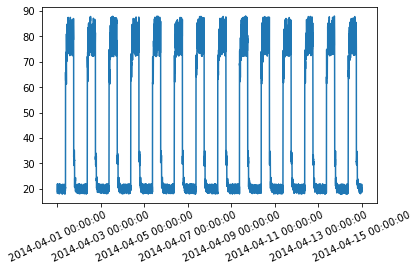

In [24]:
plot_dates_values(df_small_noise)

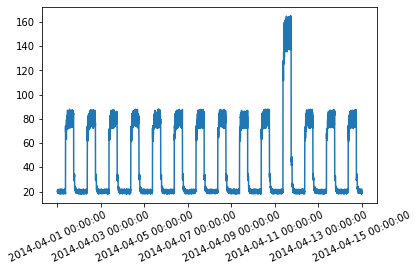

In [25]:
plot_dates_values(df_daily_jumpsup)

In [ ]:
'''Get data values from the training timeseries data file and normalize the value data. We have a value for every 5 mins for 14 days.

24 * 60 / 5 = 288 timesteps per day
288 * 14 = 4032 data points in total'''

In [26]:
def get_value_from_df(df):
    return df.value.to_list()


def normalize(values):
    mean = np.mean(values)
    values -= mean
    std = np.std(values)
    values /= std
    return values, mean, std


# Get the `value` column from the training dataframe.
training_value = get_value_from_df(df_small_noise)

# Normalize `value` and save the mean and std we get,
# for normalizing test data.
training_value, training_mean, training_std = normalize(training_value)
len(training_value)

4032

In [ ]:
'''Create sequences
Create sequences combining TIME_STEPS contiguous data values from the training data.'''

In [27]:
TIME_STEPS = 288


def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    # Convert 2D sequences into 3D as we will be feeding this into
    # a convolutional layer.
    return np.expand_dims(output, axis=2)


x_train = create_sequences(training_value)
print("Training input shape: ", x_train.shape)

Training input shape:  (3744, 288, 1)


In [ ]:
'''Build a model
We will build a convolutional reconstruction autoencoder model. 
The model will take input of shape (batch_size, sequence_length, num_features) and 
return output of the same shape. In this case, sequence_length is 288 and num_features is 1.'''

In [28]:
n_steps = x_train.shape[1]
n_features = x_train.shape[2]

keras.backend.clear_session()
model = keras.Sequential(
    [
        layers.Input(shape=(n_steps, n_features)),
        layers.Conv1D(filters=32, kernel_size=15, padding='same', data_format='channels_last',
            dilation_rate=1, activation="linear"),
        layers.LSTM(
            units=25, activation="tanh", name="lstm_1", return_sequences=False
        ),
        layers.RepeatVector(n_steps),
        layers.LSTM(
            units=25, activation="tanh", name="lstm_2", return_sequences=True
        ),
        layers.Conv1D(filters=32, kernel_size=15, padding='same', data_format='channels_last',
            dilation_rate=1, activation="linear"),
        layers.TimeDistributed(layers.Dense(1, activation='linear'))
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 288, 32)           512       
                                                                 
 lstm_1 (LSTM)               (None, 25)                5800      
                                                                 
 repeat_vector (RepeatVector  (None, 288, 25)          0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 288, 25)           5100      
                                                                 
 conv1d_1 (Conv1D)           (None, 288, 32)           12032     
                                                                 
 time_distributed (TimeDistr  (None, 288, 1)           33        
 ibuted)                                                

In [ ]:
'''Train the model
Please note that we are using x_train as both the input and the target since this is a reconstruction model.'''

In [44]:
history = model.fit(
    x_train,
    x_train,
    epochs=200,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=25, mode="min", restore_best_weights=True)
    ],
)

Epoch 1/200
27/27 [==============================] - 5s 202ms/step - loss: 0.4641 - val_loss: 0.4616
Epoch 2/200
27/27 [==============================] - 5s 203ms/step - loss: 0.5406 - val_loss: 0.5321
Epoch 3/200
27/27 [==============================] - 5s 202ms/step - loss: 0.4987 - val_loss: 0.5005
Epoch 4/200
27/27 [==============================] - 6s 208ms/step - loss: 0.5124 - val_loss: 0.4599
Epoch 5/200
27/27 [==============================] - 6s 205ms/step - loss: 0.4656 - val_loss: 0.4284
Epoch 6/200
27/27 [==============================] - 5s 202ms/step - loss: 0.4887 - val_loss: 0.4529
Epoch 7/200
27/27 [==============================] - 6s 208ms/step - loss: 0.4851 - val_loss: 0.4254
Epoch 8/200
27/27 [==============================] - 6s 208ms/step - loss: 0.4419 - val_loss: 0.4131
Epoch 9/200
27/27 [==============================] - 6s 206ms/step - loss: 0.3487 - val_loss: 0.3060
Epoch 10/200
27/27 [==============================] - 6s 211ms/step - loss: 0.2842 - val_lo

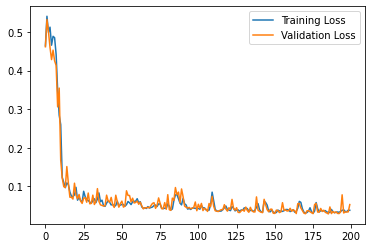

In [45]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [ ]:
'''Detecting anomalies
We will detect anomalies by determining how well our model can reconstruct the input data.

Find MAE loss on training samples.
Find max MAE loss value. This is the worst our model has performed trying to reconstruct a sample. 
We will make this the threshold for anomaly detection.
If the reconstruction loss for a sample is greater than this threshold value then we can infer that 
the model is seeing a pattern that it isn't familiar with. We will label this sample as an anomaly.'''

117/117 [==============================] - 4s 30ms/step


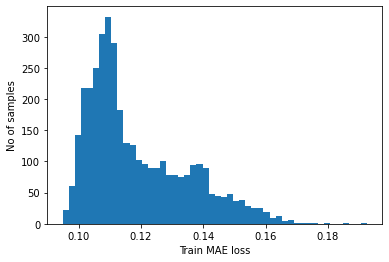

Reconstruction error threshold:  0.19252074465089417


In [46]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [ ]:
'''Compare recontruction
Just for fun, let's see how our model has recontructed the first sample. This is the 288 timesteps from day 1 
of our training dataset.'''

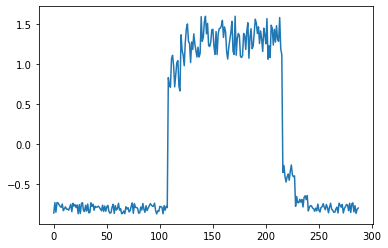

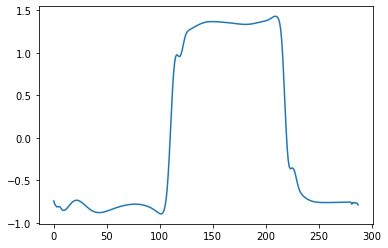

In [47]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.show()
plt.plot(x_train_pred[0])
plt.show()

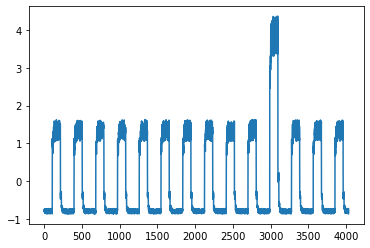

Test input shape:  (3744, 288, 1)
117/117 [==============================] - 4s 30ms/step


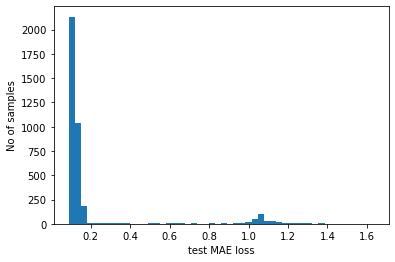

Number of anomaly samples:  391
Indices of anomaly samples:  (array([ 508, 2701, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711,
       2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722,
       2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733,
       2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744,
       2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755,
       2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766,
       2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777,
       2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788,
       2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799,
       2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810,
       2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821,
       2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832,
       2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2

In [48]:
#Prepare test data

def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values


test_value = get_value_from_df(df_daily_jumpsup)
test_value = normalize_test(test_value, training_mean, training_std)
plt.plot(test_value.tolist())
plt.show()

# Create sequences from test values.
x_test = create_sequences(test_value)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [ ]:
'''Plot anomalies
We now know the samples of the data which are anomalies. 
With this, we will find the corresponding timestamps from the original test data. 
We will be using the following method to do that:

Let's say time_steps = 3 and we have 10 training values. Our x_train will look like this:

0, 1, 2
1, 2, 3
2, 3, 4
3, 4, 5
4, 5, 6
5, 6, 7
6, 7, 8
7, 8, 9
All except the initial and the final time_steps-1 data values, will appear in time_steps number of samples.
So, if we know that the samples [(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point 5 is an anomaly.'''

In [49]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(test_value) - TIME_STEPS + 1):
    time_series = range(data_idx - TIME_STEPS + 1, data_idx)
    if all([anomalies[j] for j in time_series]):
        anomalous_data_indices.append(data_idx)

In [ ]:
'''Let's overlay the anomalies on the original test data plot.'''

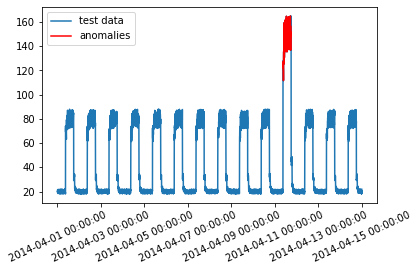

In [50]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices, :]
plt.subplots_adjust(bottom=0.2)
plt.xticks(rotation=25)
ax = plt.gca()
xfmt = mdates.DateFormatter("%Y-%m-%d %H:%M:%S")
ax.xaxis.set_major_formatter(xfmt)

dates = df_daily_jumpsup["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = df_daily_jumpsup["value"].to_list()
plt.plot(dates, values, label="test data")

dates = df_subset["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = df_subset["value"].to_list()
plt.plot(dates, values, label="anomalies", color="r")

plt.legend()
plt.show()